# BERT Spam Classification using PyTorch

Code example to classify spam messages from SMS using BERT and Torch. 
This code will have example to deal with memory issue with assuming work with large dataset

In [1]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('data/SMSSpamCollection', sep="\t", names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Use map** to modify the label

In [2]:
# replace ham with 0 and spam with 1
df.label = df.label.map({'ham': 0, 'spam': 1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Check maximum text length** because BERT have length limitation

171


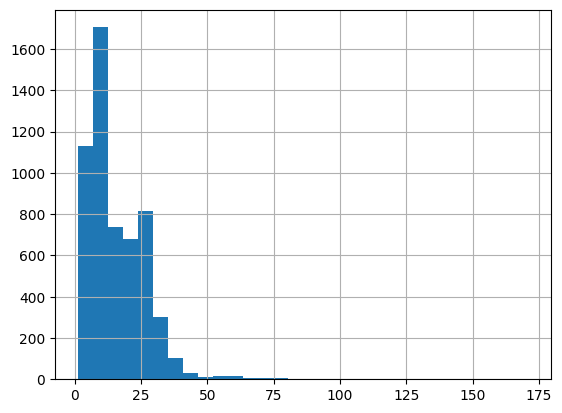

In [3]:
# count the sequence length of each message
seq_len = [len(i.split()) for i in df.message]

# Plot the histogram for the sequence length
pd.Series(seq_len).hist(bins=30)
max_seq_len = max(seq_len)
print(max_seq_len)

**Check distribution of spam and not-spam in dataset**

In [4]:
df.label.value_counts(normalize=True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

**Check distribution based on text length on spam and non-spam**

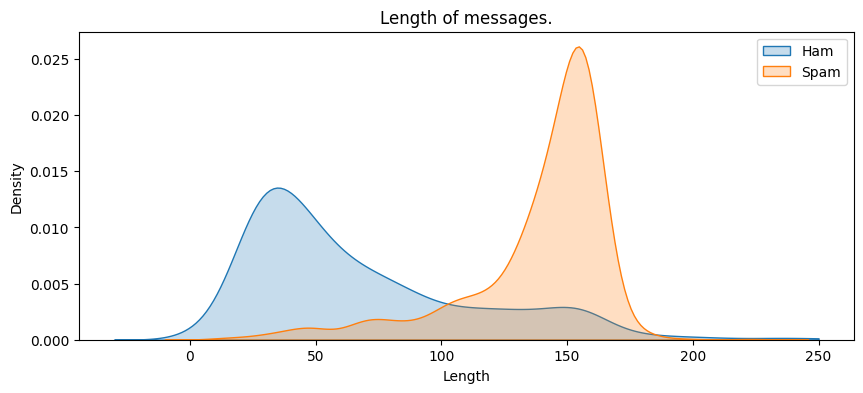

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

df['length'] = df.message.apply(len)

_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.label == 0, "length"], fill=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.label == 1, "length"], fill=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()



**Split data into training and test** and using Stratified sampling to ensure the data balance between spam and ham in training and test

In [6]:
from sklearn.model_selection import train_test_split

# split data into train and temporary validation, while keep the balance of spam portion on each
df_train, df_temp = train_test_split(df, test_size=0.1, stratify=df.label, random_state=42)

# split into validation and test, while keep the balance of spam portion on each
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp.label)

# print the portion of dataset from train, validation and test
print(len(df_train), len(df_val), len(df_test))

5014 279 279


**Remember, we don't feed raw text into BERT model** We tokenized!

In [7]:
from transformers import BertTokenizer, BertModel, DataCollatorWithPadding

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all of the sentences
text = ["I want to go to the market", "Get $400 USD now! easy money!"]

# Tokenize all of the sentences and map the tokens.
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Show the results of the tokenization that will feed into BertModel
# We don't give raw text to BertModel, we give the tokenized version
print(sent_id)

{'input_ids': [[101, 1045, 2215, 2000, 2175, 2000, 1996, 3006, 102, 0, 0], [101, 2131, 1002, 4278, 13751, 2085, 999, 3733, 2769, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


**Build DataSet class to convert DataFrame**

In [8]:
import torch
import numpy as np

class SmsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # provide a single dict contain text and label as one row of the dataframe based on given index
        return {'text': self.df.iloc[idx]['message'], 'label': self.df.iloc[idx]['label']}

In [9]:
class DynamicPaddingCollator:
    """
    What is dynamic padding for? it is used to reduce the amount of padding applied to the input text.
    Usually, we pad the input text to the maximum length param like 512, while most of the text is much shorter than that.
    So, we can use dynamic padding to reduce the amount of padding applied to the input text.

    What is DataCollatorWithPadding? it is a class from transformers library that will be used in training loop later.
    """

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.padding_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def __call__(self, batch):
        # batch contain multiple samples from SmsDataset, which the size is based on batch_size param in DataLoader
        # example of batch output is: [{'text': 'I want to go to the market', 'label': 0}, {'text': 'Get $400 USD now! easy money!', 'label': 1}}]
        texts = [item['text'] for item in batch]
        tokenized_inputs = self.tokenizer(texts, return_tensors="pt", padding="longest", truncation=True)
        labels = [item['label'] for item in batch]

        # apply dynamic padding to inputs
        new_batch = self.padding_collator(tokenized_inputs)        
        new_batch['labels'] = torch.tensor(labels).float() # or you can use tensor.stack(labels)

        # return the new batch with tokenized inputs and combined list of labels
        return new_batch

# Data Collator is a function that takes a list of samples from a Dataset and collate them into a batch, as a dictionary of Tensors.
data_collator = DynamicPaddingCollator(tokenizer=tokenizer)

In [10]:
# Wrap DataFrame into Dataset class
train_dataset = SmsDataset(df_train)
val_dataset = SmsDataset(df_val)
test_dataset = SmsDataset(df_test)

# Convert the dataset to torch tensors and apply dynamic padding using data_collator
# pin_memory=True will speed up the data loading to GPU, because samples will be copied into pinned memory
# num_workers=4 will make the data loading process faster by using 4 CPU cores
#
# shuffle=True will help to randomize the order of samples so it will not be loaded in the same order
# it is important to set shuffle=True for training dataset, but not for validation and test dataset
# this is also helping the model to generalize better, rather influenced by some pattern from samples sequence
#
# REMEMBER: Adjust batch_size based on your GPU memory capacity. I'm using 4090 24GB GPU, so I can use batch_size=48 for training
#
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4, collate_fn=data_collator, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=data_collator, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=data_collator, pin_memory=True)


In [11]:
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification

class BertClassifier(nn.Module):
    """
    Bert Neural Network classifier for spam classification
    We use dropout to prevent overfitting, linear layer to reduce the dimension of the output from BERT, and sigmoid to get the probability of the output
    """
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()

        # load the bert model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # create the dropout layer with value setup in dropout param
        self.dropout = nn.Dropout(dropout)

        # create the linear layer with 1 output, because we only have 2 classes (spam or not spam)
        self.linear = nn.Linear(768, 1) # 768 is the size of the hidden state of BERT

    def forward(self, input_ids, attention_mask):
        """
        What forward pass? it is a function that will be called when we call the model with some input.
        For example: model(input_ids, attention_mask)

        Forward pass will return the output of the model, which is the probability of the input text is spam or not spam
        one forward pass is equal to one training step, which will be used to calculate the loss and update the model weights
        """
        # input_ids is the tokenized version of the input text and attention mask is the mask for padding <pad> token
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        drop_out = self.dropout(pooled_output)

        return self.linear(drop_out).squeeze(-1)

In [12]:
from torch.optim import AdamW
from tqdm import tqdm 
from sklearn.metrics import accuracy_score

def train(model, train_data, val_data, learning_rate, epochs):
    # change this into False if you want to do debugging on training 
    use_cuda = torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")

    # criterion is the loss function, we use Binary Cross Entropy Loss with logits (recommended) than BCELoss
    criterion = nn.BCEWithLogitsLoss()

    # optimizer is the optimizer function, we use Adam optimizer
    # the purpose of optimizer is to update the weights of the neural network
    # and we will reset the gradient to zero after every epoch, to avoid gradient accumulation
    # gradient accumulation is useful for training with large batch size, but we don't use it here
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # move the model and criterion to GPU if available
    if use_cuda:
        model.to(device)
        criterion.to(device)

    # start training
    # what is epoch? it is a single pass through the entire training dataset
    # epochs vs batch size? batch size is the number of samples processed before the model is updated
    for epoch_num in range(epochs):

        # start training
        model.train()

        # after every epoch, we will reset the running loss to 0
        running_train_loss = 0.0

        # all_train_preds and all_train_labels will be used to calculate the training accuracy metric
        all_train_preds, all_train_labels = [], []

        # tqdm is used to show the progress bar
        for batch in tqdm(train_data):

            # move the input, attention mask and label to GPU if available
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass (calculate the output of the model)
            outputs = model(inputs, attention_mask) 

            # using detach because training will use grad=True, but we don't need the gradient for validation
            preds = torch.sigmoid(outputs).round().detach().cpu() 

            # calculate the loss, and accumulate the loss for every batch
            loss = criterion(outputs, labels.float())
            running_train_loss += loss.item()

            # backward pass (calculate the gradient)
            loss.backward()

            # update the model weights
            optimizer.step()

            # append the predictions and labels to calculate the accuracy later
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu())

            # reset the gradient to zero after every epoch
            optimizer.zero_grad()

        # calculate the average training loss
        avg_train_loss = running_train_loss / len(train_data)

        # calculate the training accuracy
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)

        # after every epoch, we will do validation. we will not update the model weights during validation
        # so we need to change the model to evaluation mode
        model.eval()

        running_val_loss = 0.0        
        all_preds, all_labels = [], []

        # turn off the gradient calculation to save memory and computation
        with torch.no_grad():

            # set the model to evaluation mode
            for batch in val_data:
                # move the input and label to GPU if available
                inputs = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # forward pass
                outputs = model(inputs, attention_mask)
                preds = torch.sigmoid(outputs).round().cpu()

                loss = criterion(outputs, labels.float())
                running_val_loss += loss.item()

                all_preds.extend(preds)
                all_labels.extend(labels.cpu())

                print(inputs.shape, attention_mask.shape)
                print(len(all_preds), len(all_labels))

        avg_val_loss = running_val_loss / len(train_data)
        accuracy = accuracy_score(all_labels, all_preds)

        # print the training loss, validation loss and accuracy for every epoch
        print(f"Epoch {epoch_num+1}/{epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f} | Validation Accuracy: {accuracy:.4f}")

In [13]:
from time import perf_counter

EPOCHS = 5
model = BertClassifier()
LR = 2e-5

# Start the stopwatch / counter
t1_start = perf_counter() 

# start training
train(model, train_loader, val_loader, LR, EPOCHS)

# Stop the stopwatch / counter
t1_stop = perf_counter()

print("Elapsed time during the whole program in seconds:", t1_stop-t1_start)


100%|██████████| 105/105 [00:11<00:00,  9.18it/s]


torch.Size([16, 53]) torch.Size([16, 53])
16 16
torch.Size([16, 65]) torch.Size([16, 65])
32 32
torch.Size([16, 42]) torch.Size([16, 42])
48 48
torch.Size([16, 61]) torch.Size([16, 61])
64 64
torch.Size([16, 51]) torch.Size([16, 51])
80 80
torch.Size([16, 57]) torch.Size([16, 57])
96 96
torch.Size([16, 68]) torch.Size([16, 68])
112 112
torch.Size([16, 140]) torch.Size([16, 140])
128 128
torch.Size([16, 50]) torch.Size([16, 50])
144 144
torch.Size([16, 55]) torch.Size([16, 55])
160 160
torch.Size([16, 37]) torch.Size([16, 37])
176 176
torch.Size([16, 125]) torch.Size([16, 125])
192 192
torch.Size([16, 52]) torch.Size([16, 52])
208 208
torch.Size([16, 47]) torch.Size([16, 47])
224 224
torch.Size([16, 61]) torch.Size([16, 61])
240 240
torch.Size([16, 57]) torch.Size([16, 57])
256 256
torch.Size([16, 54]) torch.Size([16, 54])
272 272
torch.Size([7, 48]) torch.Size([7, 48])
279 279
Epoch 1/5
Training Loss: 0.1404, Validation Loss: 0.0070
Training Accuracy: 0.9603 | Validation Accuracy: 0.98

100%|██████████| 105/105 [00:09<00:00, 10.72it/s]


torch.Size([16, 53]) torch.Size([16, 53])
16 16
torch.Size([16, 65]) torch.Size([16, 65])
32 32
torch.Size([16, 42]) torch.Size([16, 42])
48 48
torch.Size([16, 61]) torch.Size([16, 61])
64 64
torch.Size([16, 51]) torch.Size([16, 51])
80 80
torch.Size([16, 57]) torch.Size([16, 57])
96 96
torch.Size([16, 68]) torch.Size([16, 68])
112 112
torch.Size([16, 140]) torch.Size([16, 140])
128 128
torch.Size([16, 50]) torch.Size([16, 50])
144 144
torch.Size([16, 55]) torch.Size([16, 55])
160 160
torch.Size([16, 37]) torch.Size([16, 37])
176 176
torch.Size([16, 125]) torch.Size([16, 125])
192 192
torch.Size([16, 52]) torch.Size([16, 52])
208 208
torch.Size([16, 47]) torch.Size([16, 47])
224 224
torch.Size([16, 61]) torch.Size([16, 61])
240 240
torch.Size([16, 57]) torch.Size([16, 57])
256 256
torch.Size([16, 54]) torch.Size([16, 54])
272 272
torch.Size([7, 48]) torch.Size([7, 48])
279 279
Epoch 2/5
Training Loss: 0.0318, Validation Loss: 0.0043
Training Accuracy: 0.9916 | Validation Accuracy: 0.99

100%|██████████| 105/105 [00:09<00:00, 10.83it/s]


torch.Size([16, 53]) torch.Size([16, 53])
16 16
torch.Size([16, 65]) torch.Size([16, 65])
32 32
torch.Size([16, 42]) torch.Size([16, 42])
48 48
torch.Size([16, 61]) torch.Size([16, 61])
64 64
torch.Size([16, 51]) torch.Size([16, 51])
80 80
torch.Size([16, 57]) torch.Size([16, 57])
96 96
torch.Size([16, 68]) torch.Size([16, 68])
112 112
torch.Size([16, 140]) torch.Size([16, 140])
128 128
torch.Size([16, 50]) torch.Size([16, 50])
144 144
torch.Size([16, 55]) torch.Size([16, 55])
160 160
torch.Size([16, 37]) torch.Size([16, 37])
176 176
torch.Size([16, 125]) torch.Size([16, 125])
192 192
torch.Size([16, 52]) torch.Size([16, 52])
208 208
torch.Size([16, 47]) torch.Size([16, 47])
224 224
torch.Size([16, 61]) torch.Size([16, 61])
240 240
torch.Size([16, 57]) torch.Size([16, 57])
256 256
torch.Size([16, 54]) torch.Size([16, 54])
272 272
torch.Size([7, 48]) torch.Size([7, 48])
279 279
Epoch 3/5
Training Loss: 0.0109, Validation Loss: 0.0074
Training Accuracy: 0.9976 | Validation Accuracy: 0.98

100%|██████████| 105/105 [00:09<00:00, 10.53it/s]


torch.Size([16, 53]) torch.Size([16, 53])
16 16
torch.Size([16, 65]) torch.Size([16, 65])
32 32
torch.Size([16, 42]) torch.Size([16, 42])
48 48
torch.Size([16, 61]) torch.Size([16, 61])
64 64
torch.Size([16, 51]) torch.Size([16, 51])
80 80
torch.Size([16, 57]) torch.Size([16, 57])
96 96
torch.Size([16, 68]) torch.Size([16, 68])
112 112
torch.Size([16, 140]) torch.Size([16, 140])
128 128
torch.Size([16, 50]) torch.Size([16, 50])
144 144
torch.Size([16, 55]) torch.Size([16, 55])
160 160
torch.Size([16, 37]) torch.Size([16, 37])
176 176
torch.Size([16, 125]) torch.Size([16, 125])
192 192
torch.Size([16, 52]) torch.Size([16, 52])
208 208
torch.Size([16, 47]) torch.Size([16, 47])
224 224
torch.Size([16, 61]) torch.Size([16, 61])
240 240
torch.Size([16, 57]) torch.Size([16, 57])
256 256
torch.Size([16, 54]) torch.Size([16, 54])
272 272
torch.Size([7, 48]) torch.Size([7, 48])
279 279
Epoch 4/5
Training Loss: 0.0033, Validation Loss: 0.0066
Training Accuracy: 0.9994 | Validation Accuracy: 0.99

100%|██████████| 105/105 [00:09<00:00, 10.92it/s]


torch.Size([16, 53]) torch.Size([16, 53])
16 16
torch.Size([16, 65]) torch.Size([16, 65])
32 32
torch.Size([16, 42]) torch.Size([16, 42])
48 48
torch.Size([16, 61]) torch.Size([16, 61])
64 64
torch.Size([16, 51]) torch.Size([16, 51])
80 80
torch.Size([16, 57]) torch.Size([16, 57])
96 96
torch.Size([16, 68]) torch.Size([16, 68])
112 112
torch.Size([16, 140]) torch.Size([16, 140])
128 128
torch.Size([16, 50]) torch.Size([16, 50])
144 144
torch.Size([16, 55]) torch.Size([16, 55])
160 160
torch.Size([16, 37]) torch.Size([16, 37])
176 176
torch.Size([16, 125]) torch.Size([16, 125])
192 192
torch.Size([16, 52]) torch.Size([16, 52])
208 208
torch.Size([16, 47]) torch.Size([16, 47])
224 224
torch.Size([16, 61]) torch.Size([16, 61])
240 240
torch.Size([16, 57]) torch.Size([16, 57])
256 256
torch.Size([16, 54]) torch.Size([16, 54])
272 272
torch.Size([7, 48]) torch.Size([7, 48])
279 279
Epoch 5/5
Training Loss: 0.0014, Validation Loss: 0.0063
Training Accuracy: 0.9998 | Validation Accuracy: 0.99

**Results**   
Loss in BCELoss function is 0.0071, which is good enough for this model.   
The loss is not percentage, but the difference between the predicted value and the actual value.   
`Training Loss: 0.0066, Validation Loss: 0.0071`

While Accuracy is calculated in percentage,   
which is the number of correct prediction divided by the total number of prediction.   
`Training Accuracy: 0.9988 | Validation Accuracy: 0.9892`

In [15]:
def evaluate(model, test_dataloader):
    use_cuda = torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    total_acc_test = 0
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():

        for batch in test_dataloader:
            # move the input and label to GPU if available
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # forward pass
            outputs = model(inputs, attention_mask)
            preds = torch.sigmoid(outputs).round().cpu()

            all_test_preds.extend(preds)
            all_test_labels.extend(labels.cpu())


    accuracy = accuracy_score(all_test_preds, all_test_labels)
    print(f'Test Accuracy: {accuracy: .3f}')

evaluate(model, test_loader)

Test Accuracy:  0.982
